In [1]:
import sys
from pathlib import Path

# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))


Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


In [2]:
pip install redis[hiredis]

Note: you may need to restart the kernel to use updated packages.


## Initialise ARMAX Models and Generate Data

In [3]:
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
# y(t) = -ay(t-1) + bu(t-1) + e(t)

# True parameters
a1_true = 0.5
a2_true = 0.2
b1_true = 1
b2_true = 0.3

# First order open-loop system
A = [1, a1_true]
B = [b1_true]
C = [1]
F = [0]
L = [1]
n_samples = 1000

ol_1 = ARMAX(A, B, C, F, L)

# Second order open-loop system
A = [1, a1_true, a2_true]
B = [b1_true, b2_true]
C = [1]
F = [0]
L = [1]

ol_2 = ARMAX(A, B, C, F, L)

# First order closed-loop system
A = [1, a1_true]
B = [b1_true]
C = [1]
F = [1]
L = [1]

cl_1 = ARMAX(A, B, C, F, L)


# Second order closed-loop system
A = [1, a1_true, a2_true]
B = [b1_true, b2_true]
C = [1]
F = [1]
L = [1]

cl_2 = ARMAX(A, B, C, F, L)




## Least Squares callback

In [4]:
from indirect_identification.d_tfs import d_tfs
import numpy as np

is_verbose = False
# Least squares function
def test_ls(params, U, Y, n_a, n_b):
    """
        params: vector of parameters to test
        K:      gain of the controller for this test run. Currently assumed to be constant
        U: U_t signal
        Y: Y_t signal
    """
    if is_verbose:
        print(f"Calculating loss with params {params}")
        [print(f"Number of inputs: {len(U)}")]
        [print(f"Number of outputs: {len(Y)}")]

    params = list(params)
    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))


    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))
    H = d_tfs((C,A))

    YGU = Y - G * U
    N_hat = (1/H) * YGU

    ret_val = np.sum([N_hat**2])  # Return SSE
    if is_verbose:
        print(ret_val)
    return ret_val

## Calculate the LSE

In [5]:
def get_lse(U, Y, n_a, n_b):
    x0 = np.zeros( (n_a + n_b))
    res = optimize.least_squares(test_ls, x0, args=(U, Y, n_a, n_b))

    params_ls = res.x
    return params_ls

## Initialise the SPS Model and Search Callback

In [6]:
# Initialise SPS 
from indirect_identification.sps_indirect import SPS_indirect_model


m = 100
q = 5

model = SPS_indirect_model(m, q)

def sps_test_function(params, U, Y, n_a, n_b):
    if is_verbose:
        print("Testing", params)

    params = list(params)

    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))
        
    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays


    # Check the condition and store the result if true
    in_sps, S1 = model.open_loop_sps(G, H, Y, U, 1, 1)  # Assuming Y and U are defined
    return in_sps



### Generate Unit Vectors

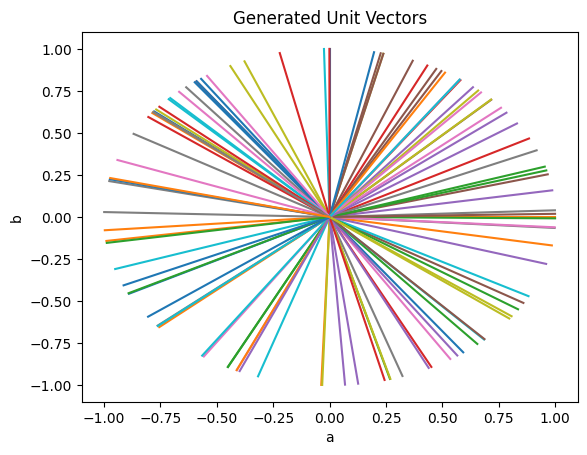

In [7]:
n_dim = 2
n_random_vectors = 100
vectors = []

# Generate Basis Vectors

v1 = np.array([0,1])
v2 = np.array([1,0])

vectors.extend([v1, v2])

for _ in range(n_random_vectors):
    rand_vec = np.random.uniform(-1, 1) * v1 + np.random.uniform(-1, 1) * v2 # Create random linear combination of basis vectors
    rand_vec /= np.linalg.norm(rand_vec)    # Normalise to create unit vector
    vectors.extend(np.array([rand_vec]))

vectors = np.array(vectors)

# Plot the vectors
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title("Generated Unit Vectors")
ax.set_xlabel("a")
ax.set_ylabel("b")

for i in range(len(vectors)):
    ax.plot([0, vectors[i, 0]], [0, vectors[i, 1]])



In [8]:

def get_unit_vectors(n_dim, n_vectors):
    basis_vectors = np.eye(n_dim)
    vectors = basis_vectors

    for _ in range(n_vectors):
        rand = np.random.uniform(-1, 1, n_dim)
        rand /= np.linalg.norm(rand)    # Normalise to create unit vector
        
        vectors = np.append(vectors, rand)

    return vectors.reshape((n_vectors + n_dim, n_dim))


In [9]:
def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)

In [ ]:
from scipy.spatial import ConvexHull

MAX_RADIUS = 1

# TODO: Add max values?
# - Max increase per iteration
def test_one_direction(unit_vector, lse, U, Y, n_a, n_b, starting_radius=0.1, epsilon=0.01, max_iterations=100):
    # scale the vector
    radius = starting_radius
    theta = np.atan2(unit_vector[1], unit_vector[0])

    # Calculate the angles of the unit vector
    thetas = []
    for i in range(n_a + n_b):
        thetas.append(np.arctan2(np.sqrt(np.sum(unit_vector[i+1:] ** 2)), unit_vector[i]))

    attempt_no = 0

    highest_true = None
    lowest_false = None

    current_error = 1

    ins = []
    outs = []
    boundary = None

    # Generate the coordinates

    while current_error > epsilon and attempt_no < max_iterations and radius < MAX_RADIUS:
        attempt_no += 1

        # Convert coordinates to cartesian
        coords = []
        prev_interim_value = 0
        for i in range(n_a + n_b):
            if i == 0:
                prev_interim_value = radius
                coords.append(lse[i] + radius * np.cos(thetas[i]))
            else:
                prev_interim_value *= np.sin(thetas[i-1])
                coords.append(lse[i] + prev_interim_value * np.cos(thetas[i]))

        in_sps = sps_test_function( tuple(coords), U, Y, n_a, n_b)

        # Update search params
        if in_sps:
            ins.append(np.array(coords))
            highest_true = radius

            if lowest_false:
                radius = highest_true + (lowest_false - highest_true) / 2
            else:
                radius *= 2

        else:
            outs.append(np.array(coords))
            lowest_false = radius

            if highest_true:
                radius = highest_true + (lowest_false - highest_true) / 2
            else:
                radius /= 2

        if highest_true and lowest_false:
            current_error = lowest_false - highest_true

    # TODO: Calculate n-dimensional boundary point
    boundary = None
    return (ins, outs, boundary)

def epoch(vectors, params_ls, U, Y, n_a, n_b):
    # Plot data
    ins = []
    outs = []
    boundaries = []

    # Sort the vectors according to angle
    vectors = sorted(vectors, key=lambda x: (np.atan2(x[1], x[0])))


    for vector in vectors:
        new_ins, new_outs, boundary= test_one_direction(vector, params_ls, U, Y, n_a, n_b)
        ins.extend(new_ins)
        outs.extend(new_outs)
        boundaries.append(boundary)


    ins = np.array(ins)
    outs = np.array(outs)
    boundaries.append(boundaries[0])
    boundaries = np.array(boundaries)

    hull = ConvexHull(ins)
    expanded_hull = expand_convex_hull(ins[hull.vertices], expansion_factor=0.01)

    return (ins, outs, boundaries, hull, expanded_hull)




In [11]:
# Plot the results
def plot_2d_results(params_ls, ins, outs, boundaries, hull, expanded_hull):
    a0 = params_ls[0]
    b0 = params_ls[1]

    fig, ax = plt.subplots()
    ax.plot(a0, b0, 'o', label="Least Squares Estimate")
    ax.plot(a1_true, b1_true, '*', c='orange', label="True Parameter", )

    if len(ins) > 0:
        ax.scatter(ins[:, 0], ins[:, 1], marker='.', c='red', label="tested in SPS")
    if len(outs) > 0:
        ax.scatter(outs[:, 0], outs[:, 1], marker='.', c='blue', label="tested not in SPS")
    # if len(boundaries) > 0:
    #     ax.plot(boundaries[:, 0], boundaries[:, 1], marker='.', c='green', label="linear boundary")
    if len(boundaries) > 0:
        ax.plot(expanded_hull[:, 0], expanded_hull[:, 1], marker='.', c='orange', label="convex hull (expanded)")
    ax.legend()

    # ax.set_xlim(-2, 2)
    # ax.set_ylim(-2, 2)
    ax.set_xlabel("a")
    ax.set_ylabel("b")

In [12]:
# Test one model

def test_model(armax_model):
    n_a = len(armax_model.A) - 1
    n_b = len(armax_model.B)
    vectors = get_unit_vectors(n_a + n_b, 10)
    # Initialise the system
    R = signal.square(np.linspace(0, 10*np.pi, n_samples))
    Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)

    # Calculate the LSE
    params_ls = get_lse(U, Y, n_a, n_b )

    return params_ls, *epoch(vectors, params_ls, U, Y, n_a, n_b)

In [13]:
len(ol_1.A)

2

In [14]:
# benchmark
import cProfile, pstats
profiler = cProfile.Profile()

# profiler.enable()
params_ls, ins, outs, boundaries, hull, expanded_hull = test_model(ol_1)
# profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()
profiler.clear()


plot_2d_results(params_ls, ins, outs, boundaries, hull, expanded_hull)


UnboundLocalError: cannot access local variable 'prev_interim_value' where it is not associated with a value